In [15]:
using Flight.FlightCore.Systems
using Flight.FlightCore.Plotting

using Flight.FlightPhysics.Geodesy
using Flight.FlightPhysics.Kinematics

using Flight.FlightComponents.Aircraft

using Flight.FlightAircraft.C172R

using ControlSystems

In [16]:
ac = Cessna172Rv0(NED()) |> System #linearization requires NED kinematics
ac.u.airframe.pld.m_pilot = 75
ac.u.airframe.pld.m_copilot = 75
ac.u.airframe.pld.m_lpass = 0
ac.u.airframe.pld.m_rpass = 0
ac.u.airframe.pld.m_baggage = 0

trim_params = C172Rv0.TrimParameters(
    loc = LatLon(),
    h = HOrth(1000),
    ψ_nb = 0.0,
    TAS = 40.0,
    γ_wOb_n = 0.0,
    ψ_lb_dot = 0.00,
    θ_lb_dot = 0.0,
    β_a = 0.0,
    fuel = 1,
    mixture = 0.5,
    flaps = 0.0)

lm = Aircraft.linearize!(ac; trim_params)

Flight.FlightComponents.Control.LinearStateSpace{16, 4, 17, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(ψ = 1, θ = 2, φ = 3, ϕ = 4, λ = 5, h = 6, p = 7, q = 8, r = 9, v_x = 10, v_y = 11, v_z = 12, α_filt = 13, β_filt = 14, ω_eng = 15, fuel = 16)}}}, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(throttle = 1, aileron = 2, elevator = 3, rudder = 4)}}}, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(ψ = 1, θ = 2, φ = 3, ϕ = 4, λ = 5, h = 6, p = 7, q = 8, r = 9, TAS = 10, α = 11, β = 12, f_x = 13, f_y = 14, f_z = 15, ω_eng = 16, m_fuel = 17)}}}, ComponentArrays.ComponentMatrix{Float64, Matrix{Float64}, Tuple{ComponentArrays.Axis{(ψ = 1, θ = 2, φ = 3, ϕ = 4, λ = 5, h = 6, p = 7, q = 8, r = 9, v_x = 10, v_y = 11, v_z = 12, α_filt = 13, β_filt = 14, ω_eng = 15, fuel = 16)}, ComponentArrays.Axis{(ψ = 1, θ = 2, φ = 3, ϕ = 4, λ = 5, h = 6, p = 7, q = 8, r = 9, v_x = 10, v_y = 

### Longitudinal Dynamics

In [17]:
long_dyn = filter(lm;
    u = (:elevator, :throttle),
    x = (:v_x, :v_z, :θ, :q, :α_filt, :ω_eng),
    y = (:q, :θ, :α, :TAS, :f_x, :f_z, :ω_eng))

long_dyn_ss = long_dyn |> ss
long_dyn_tf = long_dyn_ss |> tf

#we can reduce the model further for CAS by omitting omega_eng and throttle
pitch_dyn = filter(lm; u = (:elevator,),
    x = (:v_x, :v_z, :θ, :q, :α_filt),
    y = (:q, :θ, :α, :TAS))

pitch_dyn_ss = pitch_dyn |> ss
pitch_dyn_tf = pitch_dyn_ss |> tf


TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
Input 1 to output 1
 9.2685255061037s^4 + 199.90768179847186s^3 + 315.63256208967505s^2 + 24.976055686499507s + 0.0004574091058486829
-------------------------------------------------------------------------------------------------------------------
1.0s^5 + 26.762189022760346s^4 + 224.4230453780046s^3 + 980.3167485587944s^2 + 98.61169185678108s + 87.213147632851

Input 1 to output 2
-1.0658141036401503e-14s^4 + 9.268509148170466s^3 + 199.90732871839919s^2 + 315.6319800019441s + 24.975640707860364
-------------------------------------------------------------------------------------------------------------------
1.0s^5 + 26.762189022760346s^4 + 224.4230453780046s^3 + 980.3167485587944s^2 + 98.61169185678108s + 87.213147632851

Input 1 to output 3
 0.10240291714259797s^4 + 11.441562192613077s^3 + 188.81036233171062s^2 + 19.878198550914618s + 21.449836423146394
----------------------------------------------------------

In [18]:
#extract the elevator to q transfer function
e2q = long_dyn_tf[1,1]
@show zpk(e2q)

#the open loop TF is type 0, but with a zero almost at the origin, so in
#practice it has nearly derivative action. we can see that the steady state
#error for a step input is nearly 1, that is, the output falls back almost to
#zero
err_e2q = 1/(1+e2q)
@show zpk(err_e2q)
@show err_e2q(0)

#therefore, although adding a pure integrator will in theory yield a type 1
#system (and zero steady state error for step inputs), in practice (for
#reasonable time windows) it will still behave as a type 0. so, in addition to
#this integrator we can expect to require some more integral action in the
#feedforward path for satisfactory response.


zpk(e2q) = TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                          (1.0s + 19.860603412022122)(1.0s + 9.582561793359373)(1.0s + 1.6241216633246096)(1.0s + 0.04911481158856031)(1.0s + 3.103851263838045e-5)
9.268525506103714-----------------------------------------------------------------------------------------------------------------------------------------------------------
                 (1.0s + 16.892876910129914)(1.0s + 9.58193119398975)(1.0s^2 + 9.787166000453112s + 56.79415893385052)(1.0s^2 + 0.048202724497799415s + 0.09427302571153967)

Continuous-time transfer function model
zpk(err_e2q) = TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
   (1.0s + 16.892876910129914)(1.0s + 9.58193119398975)(1.0s^2 + 9.787166000453112s + 56.79415893385052)(1.0s^2 + 0.048202724497799415s + 0.09427302571153967)
1.0---------------------------------------------------------------------------------------------------------

1×1 Matrix{Float64}:
 0.9999949607409097

e2q_c = TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
9.268525506103714s^7 + 390.3572308803667s^6 + 5579.11785318253s^5 + 33175.80454371967s^4 + 77273.64186443604s^3 + 61015.4417401021s^2 + 2816.0341115315605s + 0.08734673104981994
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    0.05s^9 + 2.815508841453529s^8 + 60.29098102275232s^7 + 635.3298918956234s^6 + 3583.6235627332894s^5 + 9423.659527894557s^4 + 777.5625438537845s^3 + 866.6580673969248s^2

Continuous-time transfer function model
ss_err_step = e2q_c_err(0) = [0.0;;]
ss_err_ramp = (tf(1, [1, 0]) * e2q_c_err)(0) = [Inf;;]


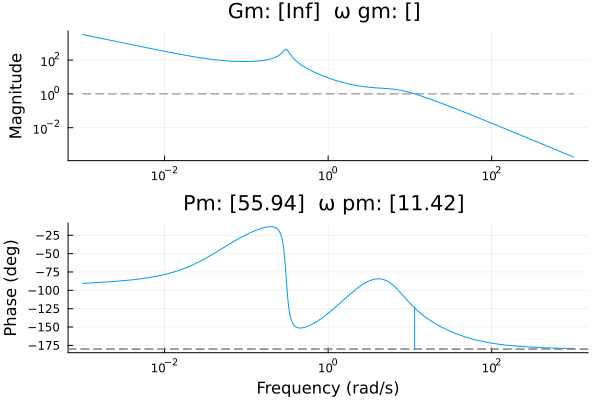

In [19]:
#we can start by trying a PID in series with the pure integrator previously
#indicated. rather than aiming for minimum steady state error (since the outward
#θ loop doesn't really care for that), we want reasonable stability margins

# k_p = 20
# k_i = 5
# k_d = 0.5
k_p = 10
k_i = 20
k_d = 0.5
q_comp = series(k_p + k_i * tf(1, [1,0]) + k_d * tf([1, 0], [0.05, 1]), tf(1, [1, 0]))
    
e2q_c = series(q_comp, e2q)
@show e2q_c

#error transfer function (setpoint - plant output)
e2q_c_err = 1/(1+e2q_c)
#the steady state error for a given test input is the final value of the ETF for
#that input. applying the final value theorem, the final value for a step input
#is found simply by settng s=0. therefore:
@show ss_err_step = e2q_c_err(0)

#and for a ramp input:
@show ss_err_ramp = (tf(1, [1, 0]) * e2q_c_err)(0)

marginplot(e2q_c)


zpk(cl) = TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                                                        (1.0s + 19.86060341202213)(1.0s + 9.582561793359378)(1.0s^2 + 8.085106382978747s + 17.02127659574473)(1.0s + 1.6241216633246078)(1.0s + 0.04911481158856024)(1.0s + 3.103851263838046e-5)
435.62069878687447----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                  (1.0s + 20.094301407659486)(1.0s + 18.323293723142037)(1.0s + 9.582176205490876)(1.0s^2 + 6.764018258683992s + 56.98464717178205)(1.0s + 4.810767311078541)(1.0s^2 + 1.6883194218318935s + 2.462078401546135)(1.0s + 0.04726946192883631)(1.0s + 3.103925487292715e-5)

Continuous-time transfer function model
poles(cl) = ComplexF64[-20.094301407659486 + 0.0im, -18.32329372314

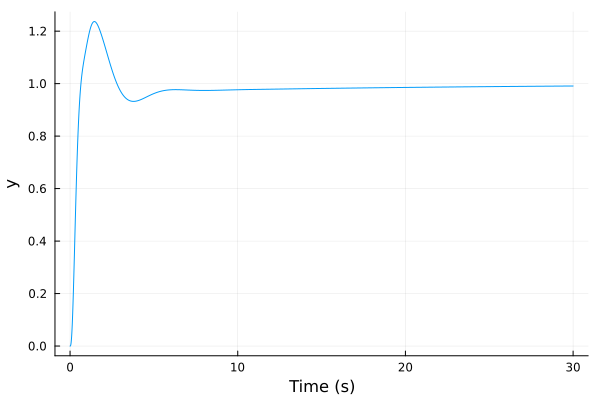

In [29]:
cl = feedback(e2q_c, 1)
@show zpk(cl)
@show poles(cl)
# bodeplot(cl)
step(cl, 10) |> plot

Now we have a SISO compensator design for q, let's use it to close the loop in the MIMO plant. The long_dyn MIMO system has two inputs, elevator position u_e and throttle position u_t. Our SISO compensator receives q_err as an input and outputs u_e. So the MIMO version of our SISO compensator, which will be placed upstream of the MIMO plant, must receive q_err and u_t as inputs and output u_e and u_t. Therefore, it must apply the SISO compensator to q_err to obtain u_e and let u_t pass through unchanged to the plant by applying an unit gain to it. This is achieved as follows:

In [21]:
q_comp_MIMO = append(q_comp, tf(1)) |> ss #should convert to ss before concatenation

StateSpace{Continuous, Float64}
A = 
 0.0  2.0    0.0
 0.0  0.0    8.0
 0.0  0.0  -20.0
B = 
 0.0  0.0
 0.0  0.0
 8.0  0.0
C = 
 3.125  3.4375  2.5
 0.0    0.0     0.0
D = 
 0.0  0.0
 0.0  1.0

Continuous-time state-space model

In [22]:
q_comp_long_dyn = series(q_comp_MIMO, long_dyn_ss) #equivalent to long_dyn_ss * q_comp_MIMO (in the product notation, the second system goes first)

StateSpace{Continuous, Float64}
A = 
 -0.17013315578161697    1.4318906490867025     -9.73823942982554       -1.127139603780563   -28.248569362537296   0.016378882774146404  -18.224483910626876  -20.046932301689566  -14.579587128501501
 -0.27853269545965303   -2.3733627812722573     -0.8717972059417747     38.40353762953182     13.897325131716865   0.000398994497457461   11.220021190755268   12.342023309830797    8.976016952604216
  1.571882671839466e-7   1.4072130392671958e-8  -9.947533095880442e-14   0.9999983285624254    0.0                 0.0                     0.0                  0.0                  0.0
  0.17693328417393517   -2.2296748212794446     -3.919644587152549e-6   -4.218693085706374    48.7259191066288     0.004363079153136224   28.964142206574035   31.860556427231437   23.171313765259228
 -0.044583898356494074   0.4980083092664152      0.0                     0.0                 -20.0                 0.0                     0.0                  0.0                  

The setpoint vector to be applied to the closed-loop MIMO system is r = [q_cmd, u_t]. The input to the MIMO compensator must be e = [q_err, u_t] = r - f = [q_cmd, u_t] - [q, 0]. So we need a matrix gain that premultiplies the 7-component output vector of long_dyn, and produces a 2-component vector [q, 0]. This will be a 2x7 matrix with all entries set to zero except [1, 1] (the nonzero output goes in the first component, and q is the first element in long_dyn's output vector)

zpk(e2q_cl_MIMO) = TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                                 (1.0s - 4.348096668287759e15)(1.0s + 19.86060323541699)(1.0s + 9.58257512897398)(1.0s + 8.701546361497986)(1.0s + 2.2984508274580877)(1.0s + 1.6241112126985968)(1.0s + 0.04911491394905805)(1.0s + 3.10387992609688e-5)
-4.263256414560601e-14----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                      (1.0s + 19.904592431730663)(1.0s^2 + 12.233644427970415s + 196.51102658591068)(1.0s + 11.923271222282107)(1.0s + 9.581717360022232)(1.0s^2 + 2.618571723446894s + 2.6050044966564663)(1.0s + 0.04834862480871063)(1.0s + 3.103880960637581e-5)

Continuous-time transfer function model


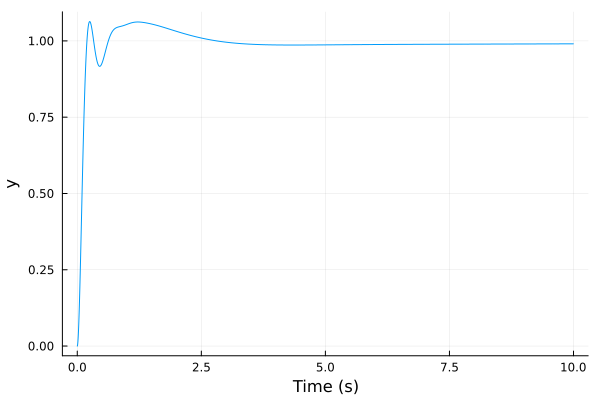

In [23]:
K_select = zeros(2, 7)
K_select[1,1] = 1
K_ss = ss(K_select) #creates a ss with no dynamics and K_select as feedthrough

#now create a feedback loop with K in the feedback path
q_comp_long_dyn_cl = feedback(q_comp_long_dyn, K_ss)

#this is similar, but NOT equivalent: it uses unit feedback, which means that
#the whole 7 component output vector from q_comp_long_dyn is fed back, and then
#multiplied by K_ss (and so reduced to 2 components) in the feedforward path
#before entering the compensator. this yields a 7 input closed loop system, of
#which only the two first inputs actually do anything (the others get discarded
# when they pass through K) q_comp_long_dyn_cl = feedback(series(K_ss,
# q_comp_long_dyn))

e2q_cl_MIMO = (q_comp_long_dyn_cl |> tf)[1,1]

#make sure the zpk data matches that of the SISO closed loop TF
@show zpk(e2q_cl_MIMO)

#check step response
step(e2q_cl_MIMO, 10) |> plot


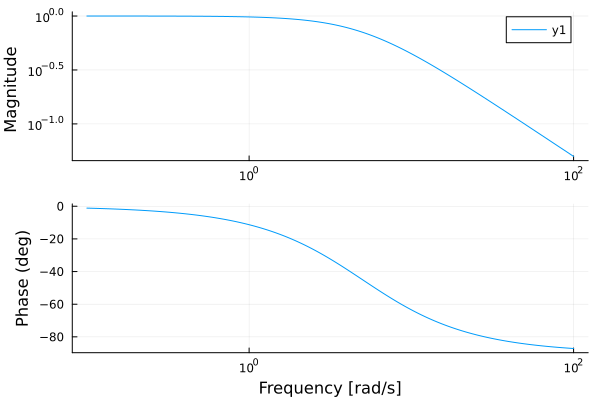

In [24]:
#let's see what we could achieve if we had an actuator in the loop with a 5Hz
#time constant

k_p = 3.4
k_i = 8
k_d = 0.3
q_comp = tf(1, [1, 0]) * (k_p + k_i * tf(1, [1,0]) + k_d * tf([1, 0], [0.05, 1]))
act = tf(1, [0.2, 1])
    
e2q_c = q_comp * act * e2q
cl = feedback(e2q_c, 1)

marginplot(e2q_c)
bodeplot(act)


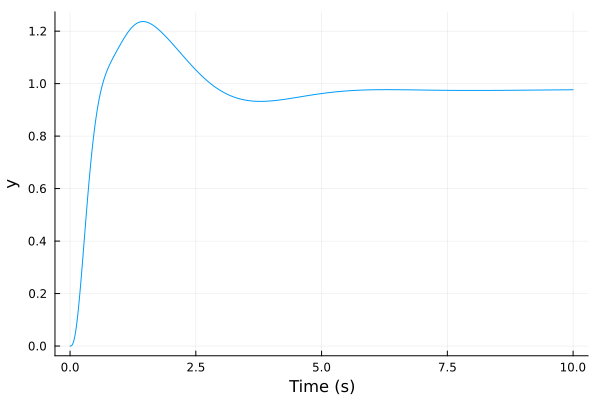

In [26]:
step(cl, 10) |> plot

In [27]:
# world = SimpleWorld(Cessna172Rv0(LTF())) |> System; #for simulation, we use LTF kinematics

In [28]:
# #trim for the trim conditions above and simulate
# (success, result) = trim!(world; trim_params)
# @assert success
# sim = Simulation(world; t_end = 30, adaptive = true)
# Sim.run!(sim, verbose = true)
# # plots = make_plots(sim; Plotting.defaults...)
# plots = make_plots(TimeHistory(sim).ac.kinematics; Plotting.defaults...)
# save_plots(plots, save_folder = joinpath("tmp", "trim_sim_test"))

## Lateral Dynamics

In [31]:
lat_dyn = filter(lm;
    u = (:aileron, :rudder),
    x = (:v_y, :φ, :ψ, :p, :r, :β_filt),
    y = (:p, :r, :φ, :ψ, :β, :f_y))

lat_dyn_ss = lat_dyn |> ss
lat_dyn_tf = lat_dyn_ss |> tf

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
Input 1 to output 1
     6.89665039592505s^5 + 144.15459313239802s^4 + 147.75811120110092s^3 + 466.0278473344505s^2 - 10.005822811592727s - 4.722171501370925e-6
-------------------------------------------------------------------------------------------------------------------------------------------------
1.0s^6 + 26.865975152349876s^5 + 147.60758471918365s^4 + 230.52412284303927s^3 + 494.6684000656438s^2 - 11.627754127761884s + 8.57185820144985e-5

Input 1 to output 2
   -0.13774600151483085s^5 - 4.522845394939566s^4 - 33.76040713203855s^3 + 37.55051702995786s^2 + 111.77027624962402s - 4.2174893941249604e-7
-------------------------------------------------------------------------------------------------------------------------------------------------
1.0s^6 + 26.865975152349876s^5 + 147.60758471918365s^4 + 230.52412284303927s^3 + 494.6684000656438s^2 - 11.627754127761884s + 8.57185820144985e-5

Input 1 to output 3


### Turn Coordination

First we focus on turn coordination. the plan is to design a SISO turn coordinator, ignoring the roll - yaw coupling for the moment. the result will be a SISO compensator with β_err as input and u_r as output. we embed it in a MIMO compensator that applies the SISO compensator to β_err and lets u_a pass through unchanged, and connect it upstream of the lateral dynamics plant. the result is then a plant with β_dmd and u_a as inputs.

From this updated plant, in a second step, we design a SISO roll rate controller with p_err as input and u_a as output. we embed it in a MIMO compensator that has p_err and β_dmd as inputs and u_a and β_dmd as outputs. of course, since roll and yaw are coupled, adding this second controller will alter the β to u_r response that resulted from the previous design, so we will have to check whether it is still satisfactory. if not, further iterations might be required.

Once the sequential design is done, we can encapsulate both SISO controllers in a single MIMO controller with a decoupled internal structure.

Maybe start with roll control. Because it looks like we can't deal with the unstable pole with a rudder input

In [34]:
yaw_dyn = filter(lm;
    u = (:rudder,),
    x = (:v_y, :φ, :ψ, :p, :r, :β_filt),
    y = (:β,))

yaw_dyn_ss = yaw_dyn |> ss
yaw_dyn_tf = yaw_dyn_ss |> tf

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
    -0.028459616494544093s^5 - 1.4610632477880472s^4 - 22.2782580706818s^3 - 88.41978608685167s^2 + 7.94016309853808s - 5.203574886679355e-6
-------------------------------------------------------------------------------------------------------------------------------------------------
1.0s^6 + 26.865975152349876s^5 + 147.60758471918365s^4 + 230.52412284303927s^3 + 494.6684000656438s^2 - 11.627754127761884s + 8.57185820144985e-5

Continuous-time transfer function model

In [85]:
r2β = minreal(yaw_dyn_tf, 1e-5)
# @show zpk(r2β)

#the first thing we notice is that the DC gain is negative. this makes sense,
#given that we have: act.rudder↑ -> aero.r↓ -> yaw↑ -> β↓. therefore, the first
#thing we need in the forward path is a sign change.
c1 = tf(-1)
c1_r2β = series(c1, r2β)
# @show zpk(c1_r2β)

#output error transfer function for a unit feedback closed loop
err_c1_r2β = 1/(1+c1_r2β)
@show zpk(err_c1_r2β)

#since the error transfer function has an unstable pole, so does the closed loop
#transfer function. therefore, it makes no sense to use the final value theorem.

k_p = 0.01
k_i = 0.1
k_d = 0.5
τ_d = 0.05
c2 = k_p + k_i * tf(1, [1,0]) + k_d * tf([1, 0], [τ_d, 1])
    
c2_c1_r2β = series(c2, c1_r2β)
err_c2_c1_r2β = 1/(1+c2_c1_r2β)
@show poles(err_c2_c1_r2β)

zpk(err_c1_r2β) = TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
   (1.0s + 5.83292605552479)(1.0s^2 + 1.0562996482672942s + 4.2869420565892105)(1.0s - 0.023243177233867183)
1.0---------------------------------------------------------------------------------------------------------
   (1.0s + 5.841274399816267)(1.0s^2 + 1.0862369650262926s + 5.064082473753453)(1.0s - 0.033069221789790264)

Continuous-time transfer function model
poles(err_c2_c1_r2β) = ComplexF64[-19.925310347751868 + 0.0im, -5.7948772515983205 + 0.0im, -0.7177792454167067 + 1.9430335212899075im, -0.7177792454167067 - 1.9430335212899075im, 0.042549880485397984 + 0.0im, -0.03766707797042335 + 0.0im]


6-element Vector{ComplexF64}:
  -19.925310347751868 + 0.0im
  -5.7948772515983205 + 0.0im
  -0.7177792454167067 + 1.9430335212899075im
  -0.7177792454167067 - 1.9430335212899075im
 0.042549880485397984 + 0.0im
 -0.03766707797042335 + 0.0im

### Roll Dynamics

In [33]:
# roll_dyn = filter(lat_dyn; u = (:aileron,),
#     x = (:v_y, :φ, :ψ, :p, :r, :β_filt),
#     y = (:p,))

# roll_dyn_ss = roll_dyn |> ss
# roll_dyn_tf = roll_dyn_ss |> tf

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
     6.89665039592505s^5 + 144.15459313239802s^4 + 147.75811120110092s^3 + 466.0278473344505s^2 - 10.005822811592727s - 4.722171501370925e-6
-------------------------------------------------------------------------------------------------------------------------------------------------
1.0s^6 + 26.865975152349876s^5 + 147.60758471918365s^4 + 230.52412284303927s^3 + 494.6684000656438s^2 - 11.627754127761884s + 8.57185820144985e-5

Continuous-time transfer function model